# Modélisation du système bactérie/anticorps

Nadir Ait Kheddache, Idriss Alaoui Soulimani, Fabien Benthami, Alma Draeger, Alexandre Janin

In [1]:
#Imports
import numpy as np
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.animation
import IPython
from IPython.display import HTML
import copy

In [284]:
#Variables globales

#Couleurs pour la vidéo
cmap = ListedColormap(['white', 'lightpink', 'lightblue', 'lightgrey'])

#True: les gb apparaissent toujours a coté d'une bactérie (défaut: True)
gb_apparait_sur_bacterie = True

#probabilité d'avoir chaque type de cellule (0: vide, 1: bactérie, 2: globule blanc, 3: nutriments)
#la somme des probabilités doit être égale à 1 (défaut: [0.6, 0.1, 0.0, 0.3])
proba = [0.6, 0.1, 0.0, 0.3]

#probabilité qu'une cellule vide se transforme en nutriments (défaut: 0.075)
proba_apparition_nutriments = 0.075

#nombre de gb qui apparait de base (défaut: 1)
nb_gb_min = 1

#nombre de gb qui apparait par bacterie à chaque étape (défaut: 0.085)
nb_gb_par_bact = 0.085

#temps de survie des bactéries sans nutriments (-1 pour désactiver) (défaut: -1)
t_survie_b = 4

#temps de survie des gb (-1 pour désactiver)
t_survie_gb = 8

#temps de survie des nutriments (-1 pour désactiver)
t_survie_n = 3

#delai avant l'apparition des GB
duree_delai = 5

#duree max de l'apparition des bacteries
duree_reaction_immunitaire = duree_delai + 150

#Symbole qui représente chaque valeur de cellule
cara = ['-', 'B', 'G', 'n']

In [256]:
def matrice(l, h, vide = False):
    """ int^2 -> int[][]
    largeur > 0, hauteur > 0
    Renvoie une matrice de 0 de l colonnes et h lignes"""
    
    if(vide):  
        return [[0 for x in range(l)] for y in range(h)]
    else:
        return [[aleatoire() for x in range(l)] for y in range(h)]

In [257]:
def aleatoire():
    """float -> int
    Renvoie le type de cellule (0, 1, 2, 3) selon le nombre aléatoire tiré"""
    
    alea = np.random.rand()
    
    for i in range(len(proba)):
        p = proba[i]
        if alea <= p:
            return i
        else:
            alea -= p
            
    return 0

In [258]:
def printmatrice(M, T):
    """int[][] -> NoneType
    Affiche la matrice M"""
    IPython.display.clear_output()
    for y in range(len(M)):
        s = ""
        for cell in M[y]:
            s += cara[cell] + ' '
            
        s += '\t'
        for t in T[y]:
            s += str(t) + ' '
        print(s + "\n")
    
    compte = compteur(M)
    
    print("Bactéries: ", compte[1], "\nGlobules blancs: ", compte[2])

In [259]:
def voisinage(M, x, y):
    """int[][] * int * int * bool-> int[]
    Renvoie la liste des voisins de la case (x, y)."""
    v = [0, 0, 0, 0]
    
    ymax = len(M)
    xmax = len(M[0])
    
    for i in [x - 1, x, x + 1]:
        if (0 <= i and i < xmax):
            for j in [y - 1, y, y + 1]:
                if (0 <= j and j < ymax):
                        if (i, j) != (x, y): #Si i, j n'est pas la case centrale
                            v[M[j][i]] += 1
    return v

In [260]:
def next_step_matrice(M, temps, nb_tour):
    """int[][]^2 -> int [][]
    Renvoie la matrice à l'étape suivante."""
    
    nv_M = list(M)
    
    compte = compteur(nv_M)
    
    for y in range(len(M)):
        for x in range(len(M[y])):
            nv_M[y][x] = next_step_cellule(x, y, M, temps)

    #nb_gb = nb_gb_min + int(nb_gb_par_bact * compte[1])
    nb_gb = max(nb_gb_min, int(nb_gb_par_bact * compte[1]))
            
    if(duree_delai <= nb_tour and nb_tour < duree_reaction_immunitaire):
        reaction_gb(nv_M, nb_gb)

    return nv_M

In [261]:
def next_step_cellule(x, y, matrice, t):
    """int * int[] -> int
    Hypothèse: c = 0 ou 1 ou 2 ou 3
    Renvoie l'état suivant d'une cellule c en fonction de son état actuel et de ses voisins."""
    
    c = matrice[y][x]
    
    voisins = voisinage(matrice, x, y)
    
    vides = voisins[0]
    bacteries = voisins[1]
    globules = voisins[2]
    nutriments = voisins[3]
    
    if (c == 0): #La cellule est vide
        if (np.random.rand() <= proba_apparition_nutriments): #Un nutriment apparait
            return 3
        else: #La cellule reste vide
            return 0
        
    if (c == 1): #Bactérie
        if (nutriments >= 1):
            t[y][x] = 0
        else:
            t[y][x] += 1
            if(t_survie_b >= 0 and t[y][x] >= t_survie_b):
                t[y][x] = 0
                return 0
        if (globules >= 1): #Les GB tuent la bactérie
            return 0
        else: #La bactérie survit
            return 1
        
    if (c == 2): #Globule blanc
        t[y][x] += 1
        if(t_survie_gb >= 0 and t[y][x] >= t_survie_gb):
            t[y][x] = 0
            return 0
        
        return 2
        
    if (c == 3): #Nutriment
        t[y][x] += 1
        if(t_survie_n >= 0 and t[y][x] >= t_survie_n):
            t[y][x] = 0
            return 0
            
        if (bacteries > 0): #La bactérie voisine se multiplie
            return 1
        else: #La cellule reste un nutriment
            return 3
        
    print("Erreur: c invalide:", c)

In [262]:
def reaction_gb(mat, nb_gb):
    h = len(mat)
    l = len(mat[0])
    
    for i in range(nb_gb):
        essais = 0
        
        while(essais < 100):
            essais += 1
            x = np.random.randint(0, l)
            y = np.random.randint(0, h)
            if((mat[y][x] == 0 or mat[y][x] == 3) and (not gb_apparait_sur_bacterie or voisinage(mat, x, y)[1] > 0)):
                mat[y][x] = 2
                break

In [263]:
def display_next_step(b):
    global mat
    global t
    global button
    global reset_button
    
    mat = next_step_matrice(mat, t)
    printmatrice(mat, t)
    
    display(reset_button)
    display(button)

In [264]:
def reset(b):
    global mat
    global t
    mat = matrice(30, 8)
    t = matrice(30, 8, True)
    printmatrice(mat, t)
    display(reset_button)
    display(button)

In [265]:
reset_button = widgets.Button(
    description='Reset',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me!',
    icon='check'
)

button = widgets.Button(
    description='Next Step',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me!',
    icon='check'
)

button.on_click(display_next_step)
reset_button.on_click(reset)

display(reset_button)
display(button)

Button(button_style='info', description='Reset', icon='check', style=ButtonStyle(), tooltip='Click me!')

Button(button_style='info', description='Next Step', icon='check', style=ButtonStyle(), tooltip='Click me!')

In [266]:
def compteur(mat):
    """int[][] -> (int, int)
    Renvoie le nombre de GB et bactéries dans une matrice"""
    compte = [0, 0, 0, 0]
    for i in mat:
        for j in i:
            compte[j] += 1
    return compte

In [267]:
def simulate_compte(l, h):
    """int * bool -> (int, int, int)
    Renvoie le nombre de GB et bactéries apres steps étapes."""
    
    mat = matrice(l, h)
    
    temps = matrice(l, h, True)
    
    resultsG = []
    resultsB = []
    resultsN = []
    
    i = 0
    
    while(i < 1000):
        compte = compteur(mat)
        resultsG.append(compte[2])
        resultsB.append(compte[1])
        resultsN.append(compte[3])
        mat = next_step_matrice(mat, temps, i)
        
        if(compte[1] == 0):
            print("Victoire du système immunitaire en {} étapes".format(i))
            break
        if(compte[2] == 0 and i >= duree_reaction_immunitaire):
            print("Fin de la réaction immunitaire innée au bout de {} étapes, victoire des bactéries".format(i))
            break
        
        i += 1
        
    return resultsG, resultsB, resultsN

Fin de la réaction immunitaire innée au bout de 163 étapes, victoire des bactéries


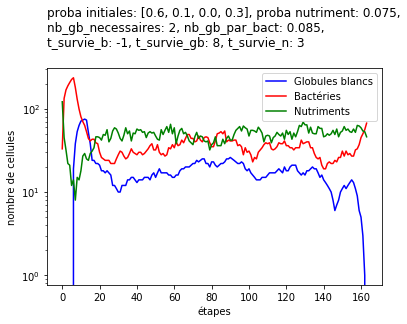

In [268]:
resultsG, resultsB, resultsN = simulate_compte(20,20)

x = list(range(len(resultsG)))

plt.plot(x, resultsG, c = 'blue', label = "Globules blancs")
plt.plot(x, resultsB, c = 'red', label = "Bactéries")
plt.plot(x, resultsN, c = 'green', label = "Nutriments")

plt.semilogy()

plt.ylabel("nombre de cellules")
plt.xlabel("étapes")

plt.legend(loc = "best")

plt.title("proba initiales: {}, proba nutriment: {},\nnb_gb_necessaires: {}, nb_gb_par_bact: {},\nt_survie_b: {}, t_survie_gb: {}, t_survie_n: {}\n".format(proba, proba_apparition_nutriments, nb_gb_necessaires, nb_gb_par_bact, t_survie_b, t_survie_gb, t_survie_n),
         loc = 'left')

plt.show()

In [269]:
def simulate_video(l, h):
    """int*int -> (bool, int)
    Renvoie True si le système immunitaire gagne, False si les bactéries gagnent + le nombre d'étapes"""
    mat = matrice(l, h)
    t = matrice(l, h, True)
    
    results = [mat]
    
    i = 0
    
    while i < 1000 :
        mat = next_step_matrice(mat, t, i)
        compte = compteur(mat)
        results.append(copy.deepcopy(mat))
        
        if(compte[1] == 0):
            print("Victoire du système immunitaire en {} étapes".format(i))
            break
        if(compte[2] == 0 and i >= duree_reaction_immunitaire):
            print("Fin de la réaction immunitaire innée au bout de {} étapes, victoire des bactéries".format(i))
            break
        
        i += 1
        
    return results

Victoire du système immunitaire en 49 étapes


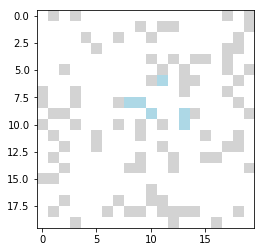

In [270]:
results = simulate_video(20, 20)

fig = plt.figure()

im = plt.imshow(results[0], animated = True, cmap = cmap)

def update(i):
    im.set_array(results[i + 1])#im = plt.matshow(results[i], cmap = cmap)
    return im,

ani = matplotlib.animation.FuncAnimation(fig, update, frames = len(results) - 1, interval = 500, blit = True)
HTML(ani.to_html5_video())
#ani.save('video1.mp4', fps = 2, extra_args=['-vcodec', 'libx264'])

In [271]:
def simulate(l, h):
    """int*int -> (bool, int)
    Renvoie True si le système immunitaire gagne, False si les bactéries gagnent + le nombre d'étapes"""
    mat = matrice(l, h)
    t = matrice(l, h, True)
    
    i = 0
    
    while i < 1000 :
        mat = next_step_matrice(mat, t, i)
        
        compte = compteur(mat)
        
        if(compte[1] == 0):
            return (True, i)
        if(compte[2] == 0 and i >= duree_reaction_immunitaire):
            return (False, i)
        
        i += 1
    
    print("On ne devrait pas voir ce message si tout se passe bien")

In [272]:
def simulate_moyenne(l, h, nb_simulations):
    """int * bool -> float
    Renvoie le nombre de GB et bactéries apres steps étapes."""
    
    mat = matrice(l, h)
    
    temps = matrice(l, h, True)
    
    nb_victoire_immu = 0
    nb_total_steps = 0
    
    for i in range(nb_simulations):
        print("Simulation "+str(i))
        victoire_immu, nb_steps = simulate(l, h)
        if(victoire_immu):
            nb_victoire_immu += 1
            nb_total_steps += nb_steps
        
    
    print("Proportion de victoire du système immmunitaire: {}, nombres d'étapes moyen: {}".format(nb_victoire_immu/nb_simulations, nb_total_steps/max(nb_victoire_immu, 1)))

In [285]:
simulate_moyenne(20, 20, 100)

Simulation 0
Simulation 1
Simulation 2
Simulation 3
Simulation 4
Simulation 5
Simulation 6
Simulation 7
Simulation 8
Simulation 9
Simulation 10
Simulation 11
Simulation 12
Simulation 13
Simulation 14
Simulation 15
Simulation 16
Simulation 17
Simulation 18
Simulation 19
Simulation 20
Simulation 21
Simulation 22
Simulation 23
Simulation 24
Simulation 25
Simulation 26
Simulation 27
Simulation 28
Simulation 29
Simulation 30
Simulation 31
Simulation 32
Simulation 33
Simulation 34
Simulation 35
Simulation 36
Simulation 37
Simulation 38
Simulation 39
Simulation 40
Simulation 41
Simulation 42
Simulation 43
Simulation 44
Simulation 45
Simulation 46
Simulation 47
Simulation 48
Simulation 49
Simulation 50
Simulation 51
Simulation 52
Simulation 53
Simulation 54
Simulation 55
Simulation 56
Simulation 57
Simulation 58
Simulation 59
Simulation 60
Simulation 61
Simulation 62
Simulation 63
Simulation 64
Simulation 65
Simulation 66
Simulation 67
Simulation 68
Simulation 69
Simulation 70
Simulation 71
Si